# **Alone in the woods**
Click original Kaggle site source https://www.kaggle.com/code/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival 

### **데이터 마이닝 라이프사이클**
<img src = 'https://www.ibm.com/docs/ko/SS3RA7_sub/modeler_crispdm_ddita/clementine/images/crisp_process.jpg'>


You shouldn't have taken that bet. 

You'll never say that to anyone if you'll ever get out of this forest - but now you should probably focus on that _getting out of the forest_ part.

Yes, you're an awesome navigator, but so deep in an unknown forest, where you can hardly see the sun, even your great skills are can't give you a clue about where you're headed.
_"I have a map"_, you said before taking the first step into the woods. True, but you lost it when you almost drowned in that river four days ago. The map didn't said how deep it was.

But you're here now, and you can still win that bet - if you'll get out here soon. But you're out of food, and you haven't seen a single fruit tree since you day one - and boy, you're a lousy hunter. 
But hey, there are mushrooms all around. hundreds, if not thousands. You can eat those - if you'd only know which ones you can. Well, can you?

_"This bet isn't worth this"_ you think. Yes, that's probably right.

In [1]:
import math
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output

In [2]:
pwd

'c:\\data_mgt\\script'

In [3]:
# ls는 linux 명령어
# 아래 명령어는 현재 작업 디렉토리의 상위 폴더 내 'input' 폴더에 있는 파일을 나열하고 "utf8" 코드형식으로 변경하라는 것임
# print(check_output(["ls", "../input"]).decode("utf8"))

In [4]:
import os

# 현재 작업 디렉토리의 상위 폴더 내 'input' 폴더에 있는 파일 나열
files = os.listdir('../input')
print(files)

['mushrooms.csv']


In [5]:
from pathlib import Path

# 현재 작업 디렉토리의 상위 폴더 내 'input' 폴더에 있는 파일 나열
p = Path('../input')
files = [x for x in p.iterdir() if x.is_file()]
print(files)

[WindowsPath('../input/mushrooms.csv')]


In [6]:
# utf-8로 변환 필요없음
# 한글 csv파일은 utf-8로 변경이 필요한 경우가 있음
data = pd.read_csv('../input/mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [7]:
data.shape

(8124, 23)

Ok, so we know about 8124 mushrooms, with 22 different attributes (23 includes the `class` column). That's a lot! You can't possibly memorise all this data. Let's try to break it down. What else do we now of our data?

In [8]:
data.isnull().values.any()

False

Good, no missing data points. What's the varience of each of the features?

In [10]:
for feature in data.columns:
    uniq = np.unique(data[feature])
    print('{}: {} distinct values -  {}'.format(feature,len(uniq),uniq))

class: 2 distinct values -  ['e' 'p']
cap-shape: 6 distinct values -  ['b' 'c' 'f' 'k' 's' 'x']
cap-surface: 4 distinct values -  ['f' 'g' 's' 'y']
cap-color: 10 distinct values -  ['b' 'c' 'e' 'g' 'n' 'p' 'r' 'u' 'w' 'y']
bruises: 2 distinct values -  ['f' 't']
odor: 9 distinct values -  ['a' 'c' 'f' 'l' 'm' 'n' 'p' 's' 'y']
gill-attachment: 2 distinct values -  ['a' 'f']
gill-spacing: 2 distinct values -  ['c' 'w']
gill-size: 2 distinct values -  ['b' 'n']
gill-color: 12 distinct values -  ['b' 'e' 'g' 'h' 'k' 'n' 'o' 'p' 'r' 'u' 'w' 'y']
stalk-shape: 2 distinct values -  ['e' 't']
stalk-root: 5 distinct values -  ['?' 'b' 'c' 'e' 'r']
stalk-surface-above-ring: 4 distinct values -  ['f' 'k' 's' 'y']
stalk-surface-below-ring: 4 distinct values -  ['f' 'k' 's' 'y']
stalk-color-above-ring: 9 distinct values -  ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
stalk-color-below-ring: 9 distinct values -  ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
veil-type: 1 distinct values -  ['p']
veil-color: 4 distin

Hmmm.. that's interesting - it seems as all known mushrooms have the same `veil-type`. We can drop this feature then, it won't help us.

In [11]:
data = data.drop(['veil-type'], axis=1)

Beore we continue, let's check if there are any duplicates in our data - meaning, do we know of two or more mushrooms with exactly the same features?

In [12]:
print('Known mushrooms: {}\nUnique mushrooms: {}'.format(len(data.index),len(data.drop_duplicates().index)))

Known mushrooms: 8124
Unique mushrooms: 8124


No, good. Wait! Are there any mushrooms with the same features but different classes?

In [15]:
data.drop_duplicates(subset=data.drop(['class'],axis=1))

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,s,o,o,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,s,o,o,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,s,o,o,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,s,k,w,w,w,o,e,w,v,l


In [16]:
print('Known mushrooms: {}\nMushrooms with same features: {}'.format(
    len(data.index),len(data.drop_duplicates(subset=data.drop(['class'],axis=1).columns).index)))

Known mushrooms: 8124
Mushrooms with same features: 8124


Ok, that's good. That's really good. Being unable to distinguish mushrooms can be deadly. 

Time to start diving deeper into the data. Let's see if there's a feature that can a better notion about the mushromm's class. More formealy, we want to know if there's a certain feature that maximizes the information about the class. For this, we will use **[Theil's U](https://en.wikipedia.org/wiki/Uncertainty_coefficient)**, also known as the _Uncertainty Coefficient_. Formaly marked as `U(x|y)`, this coefficient provides a value in the range of `[0,1]`, where 0 means that feature `y` provides no information about feature `x`, and 1 means that feature `y` provides full information abpout features `x`'s value.

In [17]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [26]:
columns = data.columns
columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [23]:
data[columns[5]]

0       p
1       a
2       l
3       p
4       n
       ..
8119    n
8120    n
8121    n
8122    y
8123    n
Name: odor, Length: 8124, dtype: object

In [37]:
for i in range(3):
    print(columns[i])
    print(theil_u(data['class'].tolist(), data[columns[i]].tolist()))
    print('*'*100)

class
1.0
****************************************************************************************************
cap-shape
0.04884222792878151
****************************************************************************************************
cap-surface
0.028616906681991437
****************************************************************************************************


In [27]:
theilu = pd.DataFrame(index=['class'],columns=data.columns)
columns = data.columns
for j in range(0,len(columns)):
    u = theil_u(data['class'].tolist(),data[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
theilu


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.0,0.048842,0.028617,0.036083,0.192559,0.90692,0.014178,0.100977,0.230369,0.417367,...,0.284991,0.272148,0.254082,0.241641,0.023839,0.038489,0.318318,0.481153,0.202146,0.15698


In [34]:
theilu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, class to class
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     1 non-null      float64
 1   cap-shape                 1 non-null      float64
 2   cap-surface               1 non-null      float64
 3   cap-color                 1 non-null      float64
 4   bruises                   1 non-null      float64
 5   odor                      1 non-null      float64
 6   gill-attachment           1 non-null      float64
 7   gill-spacing              1 non-null      float64
 8   gill-size                 1 non-null      float64
 9   gill-color                1 non-null      float64
 10  stalk-shape               1 non-null      float64
 11  stalk-root                1 non-null      float64
 12  stalk-surface-above-ring  1 non-null      float64
 13  stalk-surface-below-ring  1 non-null      float64
 14  stalk-color

In [32]:
theilu = theilu.astype(float)

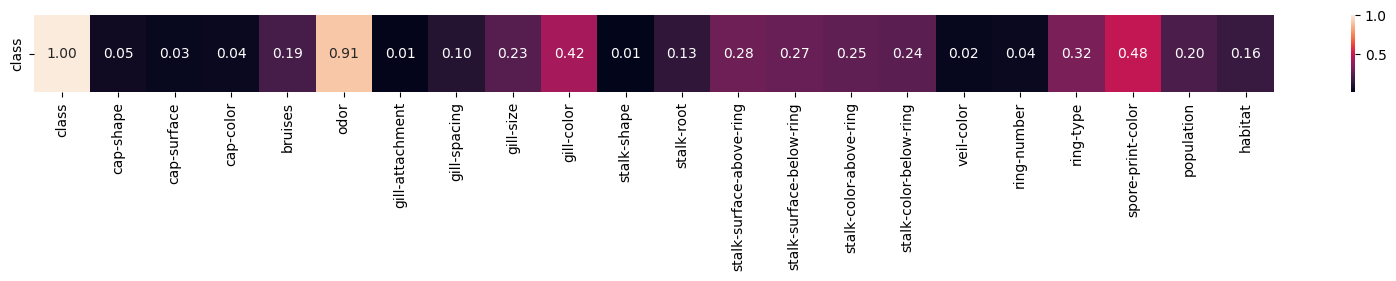

In [33]:
plt.figure(figsize=(20,1))
sns.heatmap(theilu, annot=True,fmt='.2f')
plt.show()

Seems like `odor` can be useful. Lets' take a look at that:

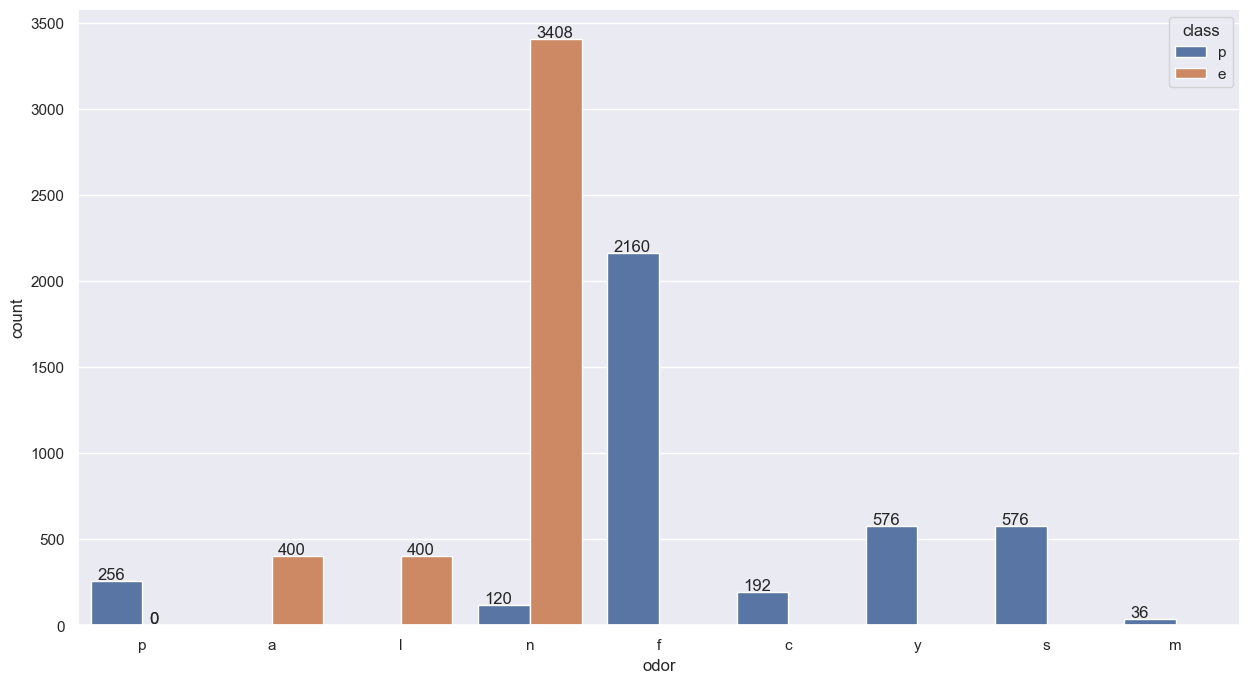

In [38]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='odor',hue='class',data=data)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

In [58]:
data[data['odor'] == 'p'][['class', 'odor']]

,class,odor
0,p,p
3,p,p
8,p,p
13,p,p
17,p,p
...,...,...
2375,p,p
2388,p,p
2400,p,p
2478,p,p


In [60]:
data[data['odor'] == 'p'][['class', 'odor']]['class'].unique()

array(['p'], dtype=object)

In [62]:
data[data['odor'] == 'p'][['class', 'odor']]['odor'].unique()

array(['p'], dtype=object)

In [64]:
data[(data['odor'] == 'p') & (data['class'] == 'p')]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
8,p,x,y,w,t,p,f,c,n,p,...,s,s,w,w,w,o,p,k,v,g
13,p,x,y,w,t,p,f,c,n,k,...,s,s,w,w,w,o,p,n,v,u
17,p,x,s,n,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,p,f,s,w,t,p,f,c,n,w,...,s,s,w,w,w,o,p,n,v,u
2388,p,x,s,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,n,v,g
2400,p,x,s,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,v,g
2478,p,f,y,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u


Ok, that's great! We can tell if a mushroom is ediable or not just by smelling it! But what about all those mushrooms with no odor (`odor='n'`)? Let's do the same trick again, but this time only for the data of these mushrooms: 

In [65]:
# slelect on odor is "n"
no_odor = data[data['odor'].isin(['n'])]
no_odor

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g
14,e,x,f,n,f,n,f,w,b,n,...,s,f,w,w,w,o,e,k,a,g
15,e,s,f,g,f,n,f,c,n,k,...,s,s,w,w,w,o,p,n,y,u
16,e,f,f,w,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g
28,e,f,f,n,f,n,f,c,n,k,...,s,s,w,w,w,o,p,k,y,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8115,e,x,s,n,f,n,a,c,b,y,...,s,s,o,o,o,o,p,o,v,l
8119,e,k,s,n,f,n,a,c,b,y,...,s,s,o,o,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,s,o,o,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,s,o,o,o,o,p,b,c,l


In [79]:
print(f"Downsized rows is from {len(data)} to {len(no_odor)} which has no smell('n' odor).")
print(f"Impurity odor(is not 'n' odor) has {len(data[data['odor'] != 'n'])} rows.")

Downsized rows is from 8124 to 3528 which has no smell('n' odor).
Impurity odor(is not 'n' odor) has 4596 rows.


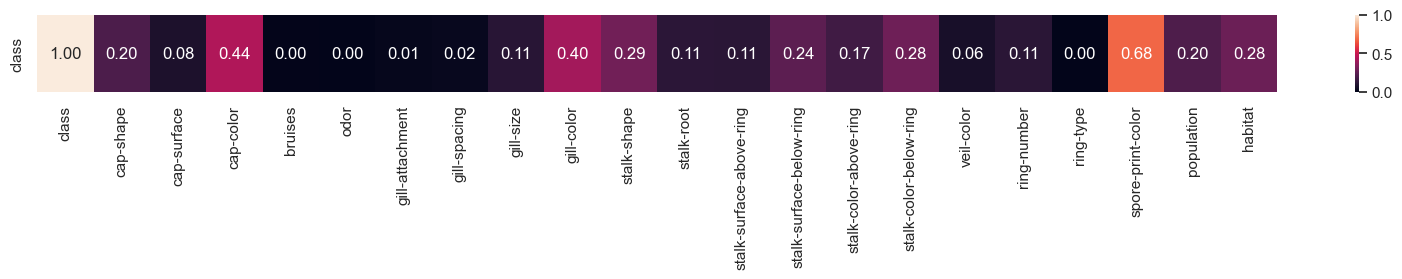

In [80]:
no_odor = data[data['odor'].isin(['n'])]

for j in range(0,len(columns)):
    u = theil_u(no_odor['class'].tolist(),no_odor[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

Now the `spore-print-color` seems like a helpful feature: 

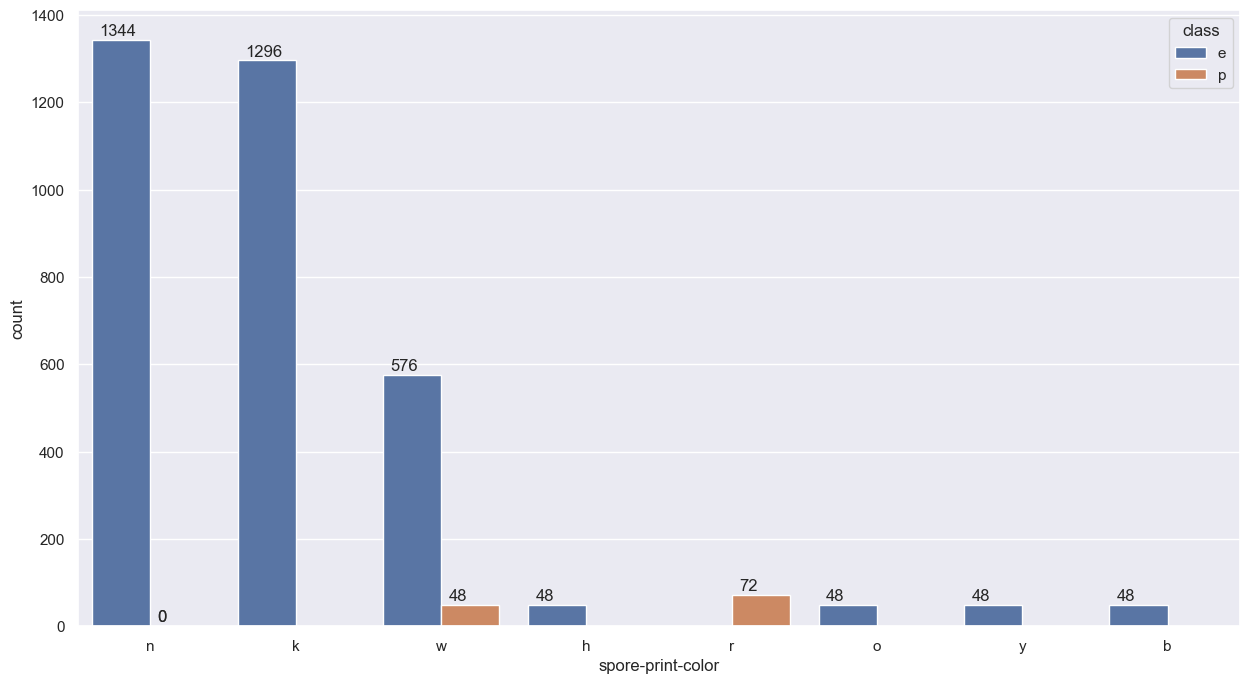

In [81]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='spore-print-color',hue='class',data=no_odor)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

Great success! We can tell odorless mushrooms apart by their spore color - unless it's white, then it's still ambiguous.

Let's see how many mushrooms are we already able telling if they're ediable or not:

In [96]:
no_odor_w = no_odor[no_odor['spore-print-color'].isin(['w'])]
print(f"Downsized rows is from {len(data)} to {len(no_odor_w)}. WOW! Bingo!")

print(f'최종적으로 Dwonsized 비율(%) : {(len(data.index) - len(no_odor_w.index)) / len(data.index)*100:.2f}%')

Downsized rows is from 8124 to 624. WOW! Bingo!
최종적으로 Dwonsized 비율(%) : 92.32%


So we can now determine the class of 92% of the mushrooms we know of. 

**Let's summarize our findings:**
* if the mushroom smells like almond (`a`) or anise (`l`), it's ediable.
* if it has no odor, check its spore color - if it's not green (`r`), it's ediable. If it's white, we're not sure.

### A little ML to speed things up:
We can keep going like this, but 92% percent classified mushroom is enough to help you find some food in the woods - and you only to remeber two things.

For the remaining 8%, let's use a Decision Tree (well, you are in the forest, aren't you?). The tree will pretty mush do what we did so far - ask the right questions to slice the data in the best way for classifications. Let's see how many branches it needs to get to perfect classification. For this, we'll need to factorize the remaining data and use one-hot encoding.

In [97]:
factorized_nw = no_odor_w.copy()

for column in factorized_nw.columns.values:
    f, _ = pd.factorize(factorized_nw[column])
    factorized_nw.loc[:,column] = f
    
ohe = sp.OneHotEncoder()
X = factorized_nw.drop(['class'],axis=1)
y = factorized_nw['class'].tolist()
ohe.fit(X)
X = ohe.transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

for i in range(1,6):
    tree = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    print("Max depth: {} - accuracy:".format(i), accuracy_score(y_test, y_pred, normalize=True))

Max depth: 1 - accuracy: 0.967948717948718
Max depth: 2 - accuracy: 0.9871794871794872
Max depth: 3 - accuracy: 0.9935897435897436
Max depth: 4 - accuracy: 0.9935897435897436
Max depth: 5 - accuracy: 1.0


Seems like we got we wanted, and we only used 50% of the data for training - so we have half of the data as our test set. Let's see some more numbers:

In [98]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       291
           1       1.00      1.00      1.00        21

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312

[[291   0]
 [  0  21]]


Amazing! We got it all classified. Come on, now - no more excuses, you got this bet now! **Good luck, and bon appetit!**

Predict from orginal data

In [112]:
factorized_nw = data.copy()

for column in factorized_nw.columns.values:
    f, _ = pd.factorize(factorized_nw[column])
    factorized_nw.loc[:,column] = f
    
ohe = sp.OneHotEncoder()
X = factorized_nw.drop(['class'],axis=1)
y = factorized_nw['class'].tolist()
ohe.fit(X)
X = ohe.transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

for i in range(1,6):
    tree = DecisionTreeClassifier(max_depth=i, random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    print("Max depth: {} - accuracy:".format(i), accuracy_score(y_test, y_pred, normalize=True))
    
print('\n\nconfusion matrix\n')
print(confusion_matrix(y_test, y_pred))

Max depth: 1 - accuracy: 0.880846873461349
Max depth: 2 - accuracy: 0.9519940915805022
Max depth: 3 - accuracy: 0.9847365829640571
Max depth: 4 - accuracy: 0.9916297390448056
Max depth: 5 - accuracy: 0.9980305268340719


confusion matrix

[[1969    8]
 [   0 2085]]


Hyperparameter

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# max_depth 값에 대한 반복
for max_depth in [3, 7, 12]:
    print(f"\nMax depth: {max_depth}")
    
    # n_estimators 값에 대한 반복
    for n_estimators in [5, 10, 15]:
        # RandomForest 모델을 초기화하고 훈련합니다.
        random_forest = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=None)
        random_forest.fit(X_train, y_train)

        # 테스트 데이터에 대한 예측을 수행합니다.
        y_pred = random_forest.predict(X_test)

        # 정확도와 Confusion Matrix를 출력합니다.
        accuracy = accuracy_score(y_test, y_pred, normalize=True)
        print(f"n_estimators: {n_estimators} - Accuracy: {accuracy}")

        # Confusion Matrix 출력
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Max depth: 3
n_estimators: 5 - Accuracy: 0.982520925652388
Confusion Matrix:
 [[1906   71]
 [   0 2085]]
n_estimators: 10 - Accuracy: 0.946824224519941
Confusion Matrix:
 [[1799  178]
 [  38 2047]]
n_estimators: 15 - Accuracy: 0.9606105366814377
Confusion Matrix:
 [[1844  133]
 [  27 2058]]

Max depth: 7
n_estimators: 5 - Accuracy: 0.9940915805022157
Confusion Matrix:
 [[1953   24]
 [   0 2085]]
n_estimators: 10 - Accuracy: 0.999015263417036
Confusion Matrix:
 [[1973    4]
 [   0 2085]]
n_estimators: 15 - Accuracy: 0.9997538158542589
Confusion Matrix:
 [[1976    1]
 [   0 2085]]

Max depth: 12
n_estimators: 5 - Accuracy: 1.0
Confusion Matrix:
 [[1977    0]
 [   0 2085]]
n_estimators: 10 - Accuracy: 1.0
Confusion Matrix:
 [[1977    0]
 [   0 2085]]
n_estimators: 15 - Accuracy: 1.0
Confusion Matrix:
 [[1977    0]
 [   0 2085]]


Ramdomgrid search